In [1]:
# Load some commonly-used packages
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import sys , os

# Load a few more useful packages
import pySPM
import spiepy

# Define some helper functions

In [2]:
def load_sxm(filepath,channel='Z',direction='forward',preflatten='True'):
    """
    Import an SXM image file and prepare it for use in SPIEPy functions.
    input 'filename' -> string
    optional Inputs -> strings
    output -> SPIEPy image object
    """
    # Load the SXM image into Python
    data = pySPM.SXM(filepath)
    image = data.get_channel(channel , direction = direction)
    data.closefile()
    # Create an empty SPIEPy image object for further use
    im = spiepy.Im()
    # Assign the  to the 'data' attribute of the new SPIEPy image object
    im.data = image.pixels
    if preflatten == 'True':
        # Pre-flatten to remove any really large-scale tilt in the original image.
        # This helps further processing steps to work better.
        im_output, _ = spiepy.flatten_xy(im)
    else:
        im_output = im.copy()
    return im_output

def create_mask(im,mask_method = 'mask_by_mean'):
    """
    Creates a mask to exclude certain parts of an image. This can be useful for excluding troublesome sections of an image during flattening.
    Inputs:
        im -> SPIEPy image object
    """
    if mask_method == 'mean':
        # Use this if this if there is contamination, but no atomic resolution
        mask = spiepy.mask_by_mean(im)
    elif mask_method == 'peak-trough':
        # Use this if there is a fair amount of contamination in the imge, but also atomic resolution
        mask , _ = spiepy.mask_by_troughs_and_peaks(im)
    elif mask_method == 'step':
        # Use this if there are step edges in the image
        mask = spiepy.locate_steps(im, 4)
    else:
        print('Unknown masking type.')
        mask = 'NaN'
    return mask

def plot_masked_image(im,mask):
    # Make a masked array, to visualize the mask superimposed over the image
    masked_image = np.ma.array(im.data, mask = mask)
    palette = spiepy.NANOMAP
    palette.set_bad('#00ff00', 1.0)
    # Show the masked image
    plt.imshow(masked_image, cmap = spiepy.NANOMAP, origin = 'lower')
    
def gen_masked_multiplot(im_unleveled , mask , im_leveled , titles = ['Masked Image' , 'Leveled Image']):
    # Generate masked image of unleveled image
    masked_image = np.ma.array(im_unleveled.data, mask = mask)
    palette = spiepy.NANOMAP
    palette.set_bad('#00ff00', 1.0)
    
    # Generate a subplot figure for plotting.
    fig , (ax1 , ax2) =  plt.subplots(1, 2)
    
    # Plot the masked image on the subplot figure
    ax1.imshow(masked_image, cmap = spiepy.NANOMAP, origin = 'lower')
    ax1.set_title(titles[0])
    # Plot the leveled image on the subplot figure
    ax2.imshow(im_leveled.data, cmap = spiepy.NANOMAP, origin = 'lower')
    ax2.set_title(titles[1])

    return fig , (ax1 , ax2)




# Import an image
The load_sxm function defined above also performs an initial first order plane fit to the image as a means of 'pre-flattening'.

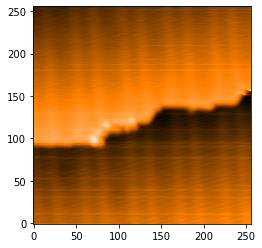

In [3]:
# Set some color pallete options from SPIEPy
palette = spiepy.NANOMAP
palette.set_bad('#00ff00', 1.0)

# Specify a file for testing purposes
path_directory = 'C:\\Users\\Jesse\\OneDrive\\Python-Stuff\\Research\\STM AI Project\\Sample_Images\\'
filename = 'STM_WTip_Au(111)_Conditioning_127.sxm'
filepath = path_directory + filename

# Load the test image
image = load_sxm(filepath)
            
# Plot the test image
plt.imshow(image.data , cmap = spiepy.NANOMAP, origin = 'lower')

# Demonstrate a few of the masking features
## Leveling with Terraces

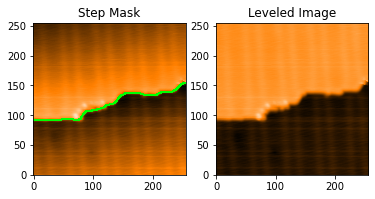

In [4]:
# Locate the step
mask_step = create_mask(image,mask_method = 'step')

# Flatten the image, taking the step into account
im_leveled_step, _ = spiepy.flatten_xy(image, mask_step)

# Make a compound plot to show the results
fig_step , axes_step = gen_masked_multiplot(image , mask_step , im_leveled_step , titles = ['Step Mask' , 'Leveled Image'])

## Leveling with mask-by-mean
This keeps everything within a certain range around the mean of all elements in the image and ignores everything outside of this range.

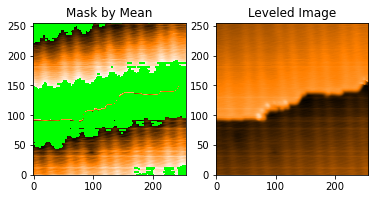

In [5]:
# Generate the mask
mask_mean = create_mask(image,mask_method = 'mean')

# Flatten the image, taking the step into account
im_leveled_mean, _ = spiepy.flatten_xy(image, mask_mean)

# Make a compound plot to show the results
fig_mean , axes_mean = gen_masked_multiplot(image , mask_mean , im_leveled_mean , titles = ['Mask by Mean' , 'Leveled Image'])

# Leveling with peak-trough mask


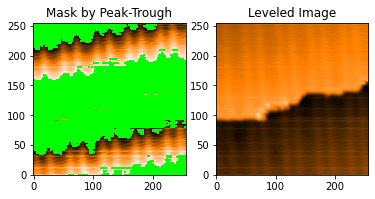

In [6]:
# Generate the mask
mask_pt = create_mask(image,mask_method = 'peak-trough')

# Flatten the image, taking the step into account
im_leveled_pt, _ = spiepy.flatten_xy(image, mask_pt)

# Make a compound plot to show the results
fig_pt , axes_pt = gen_masked_multiplot(image , mask_pt , im_leveled_pt , titles = ['Mask by Peak-Trough' , 'Leveled Image'])

# Level with a polynomial plane fit
Note: SPIEPy will only perform polynomial plane with up to second order polynomials (no cubic fitting natively).

C:\Users\Jesse\anaconda3\envs\LabWork\lib\site-packages\spiepy\flatten.py:54: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, _, _, _ = np.linalg.lstsq(g, z)


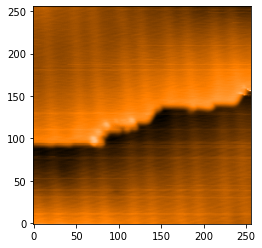

In [7]:
# Flatten the image using a quadratic plane fit.
image_poly , _ = spiepy.flatten_poly_xy(image , deg = 2)

# Show the flattened image
plt.imshow(image_poly.data , cmap = spiepy.NANOMAP, origin = 'lower')